   ## Hotel Bookings Dataset Cleaning & Analyzing Trends ##

**About the dataset**

**Columns description**

**Importing Librarries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

**Importing, Inspecting & Cleaning the dataset**

In [2]:
# importing the two csv files to dataframes.

bookings= pd.read_csv(r"C:\Users\ramez-PC\Downloads\1- datasets\Hotel Bookings\hotel_booking.csv")
codes=pd.read_csv(r"C:\Users\Ramez-PC\Downloads\1- datasets\Hotel Bookings\3Letter_Country_codes.csv")

In [3]:
# I will change the name of column ISO 3166 ALPHA-3 to 'country' so it matches the merge column.
codes.rename(columns={'ISO 3166 ALPHA-3':'country'}, inplace=True)

"""
I did the merge then i found more nulls in Country column than it should be, after investigating,
i found one country code in two letters CN so i returned here to change it to CHN before the merge.
"""
bookings.loc[bookings["country"] == "CN", "country"] = 'CHN'

Now i will correct all columns data types so i don't encounter error messages ahead.

In [4]:
bookings['is_canceled']=bookings['is_canceled'].astype(str)
bookings['arrival_date_year']=bookings['arrival_date_year'].astype(str)
bookings['arrival_date_week_number']=bookings['arrival_date_week_number'].astype(int)
bookings['arrival_date_day_of_month']=bookings['arrival_date_day_of_month'].astype(str)
bookings['is_repeated_guest']=bookings['is_repeated_guest'].astype(str)
bookings['agent']=bookings['agent'].astype(str) #
bookings['company']=bookings['company'].astype(str)
bookings['reservation_status_date'] = pd.to_datetime(bookings['reservation_status_date'])


I will make a new colum for the price of the full stay.

In [5]:
bookings['full_rate']=(bookings['stays_in_weekend_nights']+ bookings['stays_in_week_nights'])*bookings['adr']

# I will merge both datasets now and save it for dashboarding on power BI.
df=bookings.merge(codes, on='country', how='left')

# Deleting the old country column.
del df["country"]

# Replacing nulls in Country column before saving
df['Country'].fillna(method="ffill",inplace=True) 

# Saving the dataset to a csv file.
df.to_csv('Hotel_Bookings_Cleaned_UnCut.csv')

Now i will remove the bookings that were cancelled to do some EDA later

In [6]:
checkedIn = bookings[bookings["is_canceled"] == '0']
checkedIn.shape

(75166, 37)

In [7]:
# merging the 2 datasets on country column.


merged=checkedIn.merge(codes, on='country', how='left')
merged.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card,full_rate,Country
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322,0.0,Portugal
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157,0.0,Portugal


In [8]:
# Time to remove old country column that i will not use.

del merged["country"]

In [9]:
# Null values inspection.

merged.isnull().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            0
babies                              0
meal                                0
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
agent                               0
company                             0
days_in_waiting_list                0
customer_type                       0
adr         

Normally if there is an object values we replace it by the most repeated value 'mode', but I am thinking of using the ffill method, where we replace the empty cell with the value of the cell above.

In [10]:
# replacing the nulls in Country and children columns.

merged['Country'].fillna(method="ffill",inplace=True) # ffill descriped above.

In [11]:
# all coulmns dtypes after altering.

merged.dtypes

hotel                                     object
is_canceled                               object
lead_time                                  int64
arrival_date_year                         object
arrival_date_month                        object
arrival_date_week_number                   int32
arrival_date_day_of_month                 object
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                 float64
babies                                     int64
meal                                      object
market_segment                            object
distribution_channel                      object
is_repeated_guest                         object
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes     

In [12]:
# saving the cleaned dataset into another csv file.

merged.to_csv('Hotel_Bookings_Cleaned.csv')

**Exploartory Data Analysis**

In [13]:
# Inspecting tourism activity, high and low seasons
# Making a dataset of tourists count for every month and separated years

highSeason = pd.concat([merged, pd.get_dummies(merged["arrival_date_year"])], axis=1)
highSeason=(highSeason.groupby("arrival_date_month").sum()[["2015", "2016", "2017"]]
            .sort_values("2016").reset_index())

highSeason.set_index('arrival_date_month', inplace=True)

C:\Users\Ramez-PC\AppData\Local\Temp\ipykernel_15868\1420670666.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  highSeason=(highSeason.groupby("arrival_date_month").sum()[["2015", "2016", "2017"]]


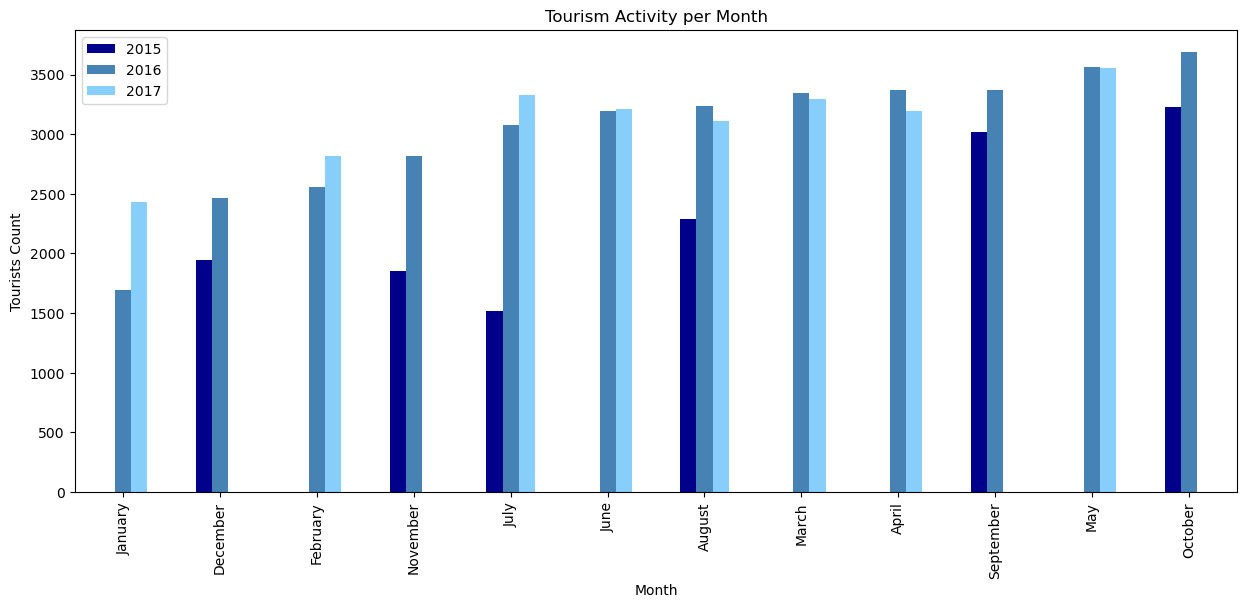

In [14]:
colors_list=['darkblue','steelblue','lightskyblue']

highSeason.plot(kind='bar', figsize=(15,6), color=colors_list)
plt.title('Tourism Activity per Month')
plt.xlabel('Month')
plt.ylabel('Tourists Count')
plt.show()

In [15]:
topCountries = pd.concat([merged, pd.get_dummies(merged["arrival_date_year"])], axis=1)
topCountries=(topCountries.groupby("Country").sum()[["2015", "2016", "2017"]]
            .sort_values("2016").reset_index()).tail(10)
topCountries.set_index('Country', inplace=True)

C:\Users\Ramez-PC\AppData\Local\Temp\ipykernel_15868\2936973866.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topCountries=(topCountries.groupby("Country").sum()[["2015", "2016", "2017"]]


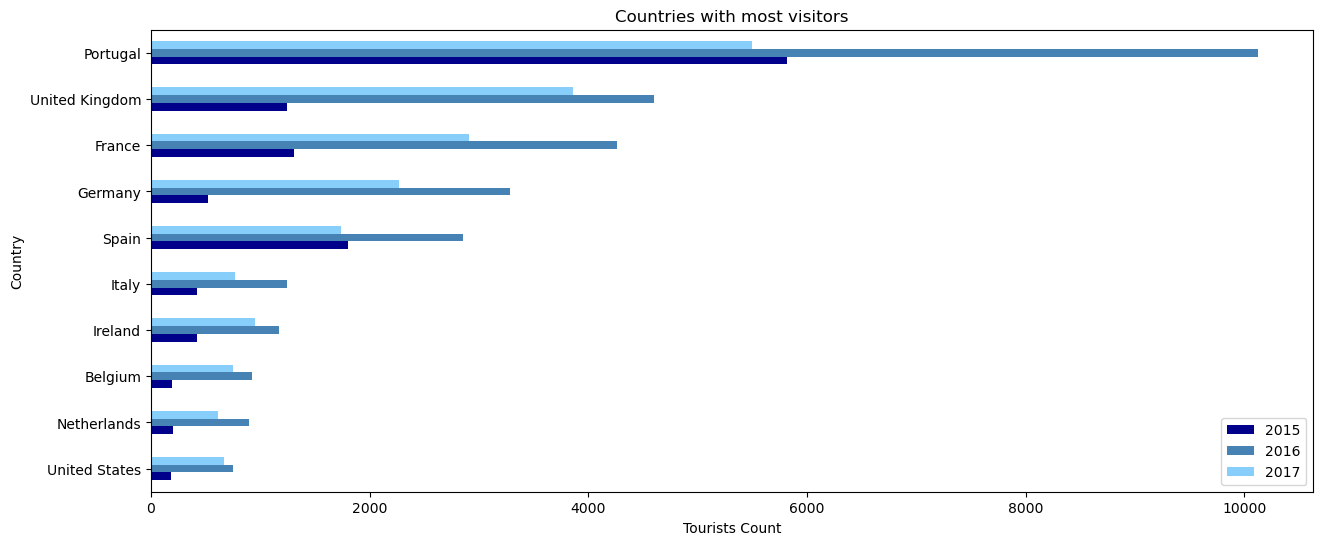

In [16]:
colors_list=['darkblue','steelblue','lightskyblue']

topCountries.plot(kind='barh', figsize=(15,6), color=colors_list)
plt.title('Countries with most visitors')
plt.xlabel('Tourists Count')
plt.ylabel('Country')
plt.show()